In [1]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Subset, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from sklearn.metrics import precision_score, recall_score, f1_score

Use Cuda if possible

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Process Data

In [3]:
# apply to validation and testing set
transform = transforms.Compose([
    transforms.Resize((160, 160)),  
    transforms.ToTensor(), 
])

# apply to training set for variability
augmentation = transforms.Compose([
    # transforms.Resize((160, 160)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(degrees=(0, 360), expand=True),
    transforms.RandomAffine(degrees=0, shear=(0.2, 0.2), translate=(0.2, 0.2)),
    transforms.RandomResizedCrop(160, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

In [4]:
T2I = transforms.ToPILImage()

In [5]:
TRAIN_DIR = "train_val_test_datasets/train/"
VAL_DIR = "train_val_test_datasets/val/"
TEST_DIR = "train_val_test_datasets/test/"

# train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=transform)
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=augmentation)
val_dataset = datasets.ImageFolder(root=VAL_DIR, transform=transform)
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


iter_loader = iter(train_loader)



Display image with augmentation to ensure it is applied correctly

Train size:  6000
Val size:  1000
test size:  3000
label unique:  tensor([0, 1])


Text(0.5, 1.0, 'Real')

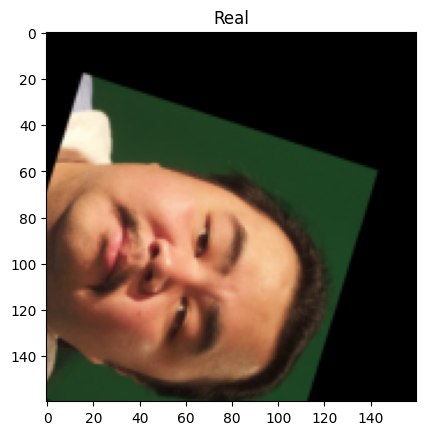

In [6]:
print("Train size: ", len(train_dataset))
print("Val size: ", len(val_dataset))
print("test size: ", len(test_dataset))

image, label = next(iter_loader)
print("label unique: ", label.unique())
image = image[0] # get first image in batch
label = label[0]
image = T2I(image)
plt.imshow(image)
label_name = "Deepfake" if label.numpy() == 0 else "Real"
plt.title(label_name)


### Define Custom MobileNet


In [7]:
# mobilenet block template
class MobileBlock(nn.Module):
    def __init__(self, nin, nout, kernel_size=3, padding=1):
        super(MobileBlock, self).__init__()

        self.depthwise = nn.Conv2d(nin, nin, kernel_size=kernel_size, padding=padding, groups=nin)
        self.batchnorm1 = nn.BatchNorm2d(nin)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)
        self.batchnorm2 = nn.BatchNorm2d(nout)

        self.leakyReLU = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        # Depthwise conv
        x = self.depthwise(x)
        x = self.batchnorm1(x)
        x = self.leakyReLU(x)

        # Pointwise conv
        x = self.pointwise(x)
        x = self.batchnorm2(x)
        x = self.leakyReLU(x)

        return x
    
class MobileDeepfake(nn.Module):
    def __init__(self):
        super(MobileDeepfake, self).__init__()

        # input -> 160x160x3

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)  # -> 160x160x8

        # mobilenet block 1
        self.mobileBlock1 = nn.Sequential(
            MobileBlock(nin=8, nout=16),                                # -> 160x160x16
            MobileBlock(nin=16, nout=16),                               # -> 160x160x16
            nn.AvgPool2d(kernel_size=2, stride=2),                      # -> 80x80x16
        )

        self.mobileBlock2 = nn.Sequential(
            MobileBlock(nin=16, nout=32),                               # -> 80x80x32
            MobileBlock(nin=32, nout=32),                               # -> 80x80x32
            MobileBlock(nin=32, nout=32),                               # -> 80x80x32
            nn.AvgPool2d(kernel_size=2, stride=2),                      # -> 40x40x32
        )

        self.mobileBlock3 = nn.Sequential(
            MobileBlock(nin=32, nout=64),                               # -> 40x40x64
            MobileBlock(nin=64, nout=64),                               # -> 40x40x64
            MobileBlock(nin=64, nout=64),                               # -> 40x40x64
            MobileBlock(nin=64, nout=64),                               # -> 40x40x64
            nn.AvgPool2d(kernel_size=2, stride=2),                      # -> 20x20x64
        )

        self.mobileBlock4 = nn.Sequential(
            MobileBlock(nin=64, nout=128, kernel_size=5, padding=2),    # -> 20x20x128
            nn.MaxPool2d(kernel_size=2, stride=2)                       # -> 10x10x128
        )

        self.mobileBlock5 = nn.Sequential(
            MobileBlock(nin=128, nout=256, kernel_size=5, padding=2),   # -> 10x10x256
            nn.MaxPool2d(kernel_size=2, stride=2)                       # -> 5x5x256
        )

        self.flatten_and_dropout = nn.Sequential(
            nn.Flatten(),                                               # -> 1x6400
            nn.Dropout(p=0.2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(6400, 32),                                        # -> 1x32   
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(32, 16),                                          # -> 1x16   
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2)
        )

        self.fc3 = nn.Sequential(
            nn.Linear(16, 1),                                           # -> 1x1  
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.mobileBlock1(x)
        x = self.mobileBlock2(x)
        x = self.mobileBlock3(x)
        x = self.mobileBlock4(x)
        x = self.mobileBlock5(x)

        x = self.flatten_and_dropout(x)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        # out = x
        out = self.sigmoid(x)

        return out


### Define Training and Validation Loop


In [8]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total_val = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.float().to(device)

        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))

        # calc accuracy
        preds = (outputs.squeeze(1) > 0.5).float()
        correct += (preds == labels).sum().item()

        # backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        total_val += labels.size(0)

    epoch_loss = running_loss / total_val
    accuracy = 100 * (correct / total_val)
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)
    return epoch_loss, accuracy

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.float().to(device)

            # forward
            outputs = model(inputs)
            # print("output shape: ", outputs.shape)
            loss = criterion(outputs, labels.unsqueeze(1))

            # calc accuracy
            preds = (outputs.squeeze(1) > 0.5).float()
            correct += (preds == labels).sum().item()

            running_loss += loss.item() * inputs.size(0)
            total_val += labels.size(0)
        
    epoch_loss = running_loss / total_val
    accuracy = 100 * (correct / total_val)
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)
    return epoch_loss, accuracy


# call training and val loop
mobile_deepfake_model = MobileDeepfake().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(mobile_deepfake_model.parameters(), lr=0.01)

num_epochs = 100

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(mobile_deepfake_model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(mobile_deepfake_model, val_loader, criterion, device)

    print(f"Epoch {epoch + 1}/{num_epochs}\n"
          f"   Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}%\n"
          f"   Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}%")
    
    # Check if the current validation accuracy is the best so far
    # if val_accuracy > best_val_accuracy:
    #     best_val_accuracy = val_accuracy
    #     # Save the model
    #     torch.save(mobile_deepfake_model.state_dict(), "best_mobile_deepfake_model.pth")
    #     print(f"New best model saved with validation accuracy: {best_val_accuracy:.4f}%")

Epoch 1/100
   Train Loss: 0.6928, Train Accuracy: 49.9833%
   Val Loss: 0.6928, Val Accuracy: 50.0000%


KeyboardInterrupt: 

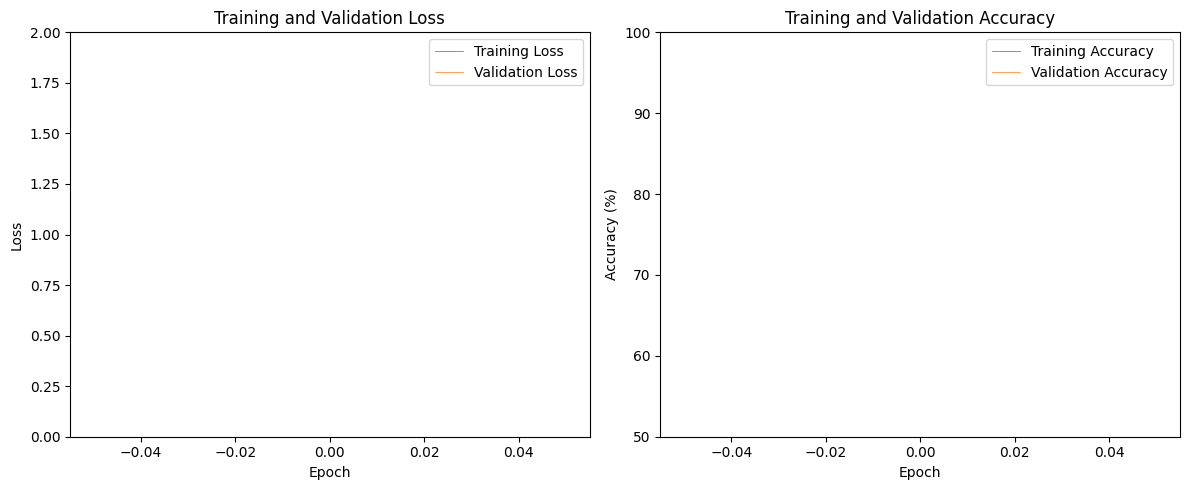

1


In [9]:
# Plot the training and validation loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', linewidth=0.5)
plt.plot(val_losses, label='Validation Loss', linewidth=0.5)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 2)
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', linewidth=0.5)
plt.plot(val_accuracies, label='Validation Accuracy', linewidth=0.5)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(50, 100)
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

print(len(train_accuracies))


In [10]:
def test(model, dataloader, criterion, device):
    model.to(device)
    model.eval()
    running_loss = 0.0
    correct = 0
    total_test = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.float().to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))

            # Calculate predictions and accuracy
            preds = (outputs.squeeze(1) > 0.5).float()
            correct += (preds == labels).sum().item()

            running_loss += loss.item() * inputs.size(0)
            total_test += labels.size(0)

            # Store predictions and labels for analysis
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate test loss and accuracy
    test_loss = running_loss / total_test
    test_accuracy = 100 * (correct / total_test)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy, all_preds, all_labels

pretrained_model = MobileDeepfake()
pretrained_model.load_state_dict(torch.load('best_mobile_deepfake_model.pth'))
test_loss, test_accuracy, predictions, true_labels = test(pretrained_model, test_loader, criterion, device)

print(f"Final Test Accuracy: {test_accuracy:.2f}%")
 
 

C:\Users\Devin\AppData\Local\Temp\ipykernel_23512\3138491596.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model.load_state_dict(torch.load('best_mobile_de

Test Loss: 0.0882, Test Accuracy: 96.83%
Final Test Accuracy: 96.83%


In [11]:
# Convert to numpy arrays
predictions = np.array(predictions).astype(int)
true_labels = np.array(true_labels).astype(int)

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

# Print the results
print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.9643
Recall: 0.9727
F1 Score: 0.9685


In [12]:
"""Uncomment one of these to test image. You can provide your own path as well"""
# test_image_path = "manual_test_images/deepfake/i_4.png"
# test_image_path = "manual_test_images/deepfake/i_15.png"
# test_image_path = "manual_test_images/real/i_5091.jpg"
test_image_path = "manual_test_images/real/i_5137.jpg"

test_image = Image.open(test_image_path)

test_image = transform(test_image).unsqueeze(0).to(device) # add batch dimension

pretrained_model = MobileDeepfake()
pretrained_model.load_state_dict(torch.load('best_mobile_deepfake_model.pth'))
pretrained_model.to(device)
pretrained_model.eval()

with torch.no_grad():
    output = pretrained_model(test_image)
    probability = output.item() 

    if probability < 0.5:
        print(f"Prediction: Deepfake (Probability: {probability * 100:.4f}%)")
    else:
        print(f"Prediction: Real (Probability: {probability * 100:.4f}%)")


Prediction: Real (Probability: 100.0000%)


C:\Users\Devin\AppData\Local\Temp\ipykernel_23512\1050195566.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model.load_state_dict(torch.load('best_mobile_de